## About
This program backtests the following trading strategies:
- Bollinger bands:
    - Entry: the price is below the lower Bollinger band, i.e. 20-day simple moving average - 2$\sigma$ (buy on the nex day's open).
    - Exit: the price is above the upper Bollinger band, i.e. 20-day simple moving average + 2$\sigma$ (sell on the nex day's open).
- RSI:
    - Entry: 10-period RSI below 30 and the price is above the 200-day moving average (buy on the nex day's open).
    - Exit: 10-period RSI above 40 or after 10 trading days (sell on the next day's open).
- RSI + Bollinger bands:
    - Entry: 10-period RSI below 30, the price is above the 200-day moving average, and the price is above the upper Bollinger band (buy on the nex day's open).
    - Exit: 10-period RSI above 40 or after 10 trading days (sell on the next day's open). 

## Import modules

In [1]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import seaborn as sns
sns.set_style('darkgrid')

## Define the functions for each strategy

In [2]:
def get_signal_bband(close, length=20):
    """
    Pass in a time series of closing price and an optional length for 
    the simple moving average, returns the buying and selling dates.
    Bollinger bands trading strategy:
    - Entry: the price is below the lower Bollinger band, i.e. 
    20-day simple moving average - 2$\sigma$ (buy on the nex day's open).
    - Exit: the price is above the upper Bollinger band, i.e. 
    20-day simple moving average + 2$\sigma$ (sell on the nex day's open).    
    """
    buy_date = []
    sell_date = []
    open_pos = False
    
    if (len(close) > length):
        # Calculate the Bollinger bands
        bbands = ta.bbands(close, length=length)
        df = pd.DataFrame({'Close':close,'BBL':bbands.iloc[:,0], 
                           'BBM':bbands.iloc[:,1],'BBU':bbands.iloc[:,2]})
        df = df.dropna()

        for i in range(len(df['Close'])-1):
            if open_pos == False:
                # Buy tomorrow if the value is lower than the low band
                if df['Close'].iloc[i] < df['BBL'].iloc[i]:
                    buy_date.append(df['Close'].index[i+1])
                    open_pos = True
            elif open_pos == True:
                # Sell tomorrow if the value is higher than the upper band
                if df['Close'].iloc[i] > df['BBU'].iloc[i]:
                    sell_date.append(df['Close'].index[i+1])
                    open_pos = False
                    
        # Remove the last buy date if there is no sell date
        if open_pos == True:
            buy_date.pop()
    return buy_date, sell_date

In [3]:
def get_signal_rsi(close, max_hold_days=10, min_rsi=30,
                   max_rsi=40, length_rsi=10, length_sma=200):
    """
    Pass in a time series of closing price, optional maximum holding days, 
    minimum and the maximum rsi (relative strength index) for entering and exiting, 
    the window for calculating the rsi, and the length for the simple moving average, 
    returns the buying and selling dates.
    RSI trading strategy:
    - Entry: 10-period RSI below 30 and the price is above the 200-day moving average (buy on the nex day's open).
    - Exit: 10-period RSI above 40 or after 10 trading days (sell on the next day's open).   
    """    
    buy_date = []
    sell_date = []
    
    # Make sure that it has enough data
    if (len(close) > length_sma+max_hold_days+1):  
        # Calculate RSI and the standard moving average
        df = pd.DataFrame({'Close': close})
        df['RSI'] = ta.rsi(df['Close'], length=length_rsi)
        df['SMA'] = ta.sma(df['Close'], length=length_sma)
        # Replace None with NaN
        df = df.fillna(value=np.nan)
        
        # Get the buying signal
        df['Signal'] = np.where((df['Close'] > df['SMA']) \
                              & (df['RSI'] < min_rsi), True, False)
        
        # Get the buying and selling dates
        for i in range(len(df['Signal']) - (max_hold_days+1)):
            if df['Signal'].iloc[i] == True: 
                # Buy tomorrow
                buy_date.append(df['Signal'].index[i+1])
                # Sell if the maximum holding day has been reached or
                # RSI is above max_rsi on the next day
                for j in range(1,max_hold_days+1):
                    if df['RSI'].iloc[i+j] > max_rsi:
                        sell_date.append(df['Signal'].index[i+j+1])
                        break                       
                    elif j == max_hold_days:
                        sell_date.append(df['Signal'].index[i+j+1])
                    
    # Avoid overlapping position
    df2 = pd.DataFrame({'buy date':buy_date, 'sell date':sell_date})
    no_ovlp = df2[df2['buy date'] > df2['sell date'].shift(1)]
    # Add the first trade
    no_ovlp = df2[:1].append(no_ovlp)
    return no_ovlp['buy date'], no_ovlp['sell date']

In [4]:
def get_signal_rsi_bband(close, max_hold_days=10, min_rsi=30, 
                         max_rsi=40, length_rsi=10, length_sma=200, 
                         length_bband=20):
    """
    Pass in a time series of closing price, optional maximum holding days, 
    minimum and the maximum rsi (relative strength index) for entering and exiting, 
    the window for calculating the rsi, the length for the simple moving average, 
    the length for calculating the bollinger bands, returns the buying and selling dates.
    RSI + Bollinger bands trading strategy:
    - Entry: 10-period RSI below 30, the price is above the 200-day moving average, 
    and the price is above the upper Bollinger band (buy on the nex day's open).
    - Exit: 10-period RSI above 40 or after 10 trading days (sell on the next day's open). 
    """      
    buy_date = []
    sell_date = []
    
    # Make sure that it has enough data
    if (len(close) > length_sma+max_hold_days+1):
        # Calculate RSI and the standard moving average
        df = pd.DataFrame({'Close': close})
        df['RSI'] = ta.rsi(df['Close'], length=length_rsi)
        df['SMA'] = ta.sma(df['Close'], length=length_sma)
        # Calculate the Bollinger bands
        bband = ta.bbands(df['Close'], length=length_bband)
        df['Low BBAND'] = bband.iloc[:,0]
        df['Up BBAND'] = bband.iloc[:,2]        
        # Replace None with NaN
        df = df.fillna(value=np.nan)
        # Drop NaN values
        df = df.dropna()
        
        # Get the buying signal using RSI strategy
        df['Buy RSI'] = np.where((df['Close'] > df['SMA']) & 
                                 (df['RSI'] < min_rsi), True, False)
        
        # Get the buying and selling signals using BBAND strategy
        df['Buy BBAND'] = np.where(df['Close'] < df['Low BBAND'], 
                                   True, False)
        
        # Get the buying and selling dates
        for i in range(len(df['Buy RSI']) - (max_hold_days+1)):
            if (df['Buy RSI'].iloc[i] == True &
                df['Buy BBAND'].iloc[i] == True):
                # Buy tomorrow
                buy_date.append(df['Buy RSI'].index[i+1])
                # Sell if the maximum holding day has been reached or
                # RSI is above max_rsi on the next day
                for j in range(1,max_hold_days+1):
                    if df['RSI'].iloc[i+j] > max_rsi :
                        sell_date.append(df['Buy RSI'].index[i+j+1])
                        break
                    elif j == max_hold_days:
                        sell_date.append(df['Buy RSI'].index[i+j+1])

    # Avoid overlapping position
    df2 = pd.DataFrame({'buy date':buy_date, 'sell date':sell_date})
    no_ovlp = df2[df2['buy date'] > df2['sell date'].shift(1)]
    # Add the first trade
    no_ovlp = df2[:1].append(no_ovlp)
    return no_ovlp['buy date'], no_ovlp['sell date']

## Define the backtesting related functions

In [5]:
def backtest_strategy(tickers, hist, start_date, end_date, strategy='bband'):
    """
    Pass in a list of ticker symbols, a dataframe containing the time series of closing price of each symbol,
    start and end dates, and the strategy for backtesting, returns a matrix containing the profit/loss from
    each transaction and a matrix containing the holding periods from each transaction.
    """ 
    matrixprofits = []
    matrixholddays = []
    for t in tickers:
        df = pd.DataFrame(hist[t].dropna())
        if (len(df) > 0):
            # Remove rows with duplicated indices
            df = df[~df.index.duplicated(keep='first')]

            # Select the method
            switcher = {
                'bband': get_signal_bband(df['Close'].dropna()),
                'rsi': get_signal_rsi(df['Close'].dropna()),
                'rsi_bband': get_signal_rsi_bband(df['Close'].dropna())
            }

            buy_date, sell_date = switcher.get(strategy, "nothing")
            
            # Store the average holding period
            hold_day = []
            for buy, sell in zip(buy_date, sell_date):
                hold_day.append(sell - buy)
            matrixholddays.append(hold_day)

            # Fetch the buying and selling prices
            buy_sell = pd.DataFrame({'Buy': df.loc[buy_date,'Open'], 
                                     'Sell': df.loc[sell_date,'Open']})
            buy_sell['Sell'] = buy_sell['Sell'].shift(-1)
            buy_sell.dropna(inplace=True)
            buy_sell = buy_sell.loc[start_date:end_date]

            # Store the profits
            profit = (buy_sell['Sell'] - buy_sell['Buy'])/buy_sell['Buy']
            matrixprofits.append(profit.values)

    return matrixprofits, matrixholddays

In [6]:
def calc_backtest_profit(matrixprofits, cut_loss=None, take_profit=None):
    allprofit = []
    for i in matrixprofits:
        for e in i:
            allprofit.append(e)
    if cut_loss is not None:
        allprofit = [max(cut_loss,i) for i in allprofit]
    if take_profit is not None:
        allprofit = [min(take_profit,i) for i in allprofit]        
        
    win = [i for i in allprofit if i > 0]
    loss = [i for i in allprofit if i < 0]
    prob_win = len(win)/(len(allprofit)+1e-6)
    kelly = prob_win-((1-prob_win)/
                      (np.mean(win)/np.absolute(np.mean(loss))))
    print(f'Number of transactions: {len(allprofit)}')    
    print(f'Winning probability: {np.round(100*prob_win, 2)}%')
    print(f'Mean return: {np.round(100*np.mean(allprofit), 2)}%')
    print(f'Mean profit: {np.round(100*np.mean(win), 2)}%')
    print(f'Mean loss: {np.round(100*np.mean(loss), 2)}%')    
    print(f'Kelly criterion: {np.round(100*kelly, 2)}%')    

In [7]:
def calc_backtest_effective_annual_return(matrixprofits, matrixholddays, 
                                          cut_loss=None, take_profit=None):
    allprofit = []
    for i in matrixprofits:
        for e in i:
            allprofit.append(e)
    if cut_loss is not None:
        allprofit = [max(cut_loss,i) for i in allprofit]
    if take_profit is not None:
        allprofit = [min(take_profit,i) for i in allprofit]        

    # Average holding days
    allholdday = []
    for e in matrixholddays:
        for i in e:
            allholdday.append(i.days)
    print(f'Mean holding period: {np.round(np.mean(allholdday),2)} days')
    
    # Effective annual return
    ann_return = 100* np.round(np.power(1+np.mean(allprofit),
                                        365/np.mean(allholdday))-1, 2)
    print(f'Annual effective return: {ann_return}%')

In [8]:
def calc_backtest_bet_return(matrixprofits, one_bet=100, 
                             cut_loss=None, take_profit=None):
    allprofit = []
    for i in matrixprofits:
        for e in i:
            allprofit.append(e)
    if cut_loss is not None:
        allprofit = [max(cut_loss,i) for i in allprofit]
    if take_profit is not None:
        allprofit = [min(take_profit,i) for i in allprofit]
    
    returns = 0
    for profit in allprofit:
        returns = returns + (one_bet*profit)
    print(f'If you follow the trading strategy and put {one_bet} USD for each transaction,')
    print(f'Your profit will be {np.round(returns)} USD after {len(allprofit)} number of transactions')        

In [9]:
def plot_backtest_profit_hist(matrixprofits, matrixholddays, 
                              cut_loss=None, take_profit=None):
    allprofit = []
    for i in matrixprofits:
        for e in i:
            allprofit.append(e)
    if cut_loss is not None:
        allprofit = [max(cut_loss,i) for i in allprofit]
    if take_profit is not None:
        allprofit = [min(take_profit,i) for i in allprofit]  

    # Percent profit
    allprofit = np.dot(100,allprofit)
    hist = np.histogram(allprofit, bins='auto')
    median = np.median(allprofit)
    mode = hist[1][np.argmax(hist[0])]
    plt.figure(figsize=(10,4))
    plt.hist(allprofit, bins='auto')
    plt.axvline(x=median, lw=4, ls='-.', label='median = '+ str(round(median, 1)), c='orange')
    plt.axvline(x=mode, lw=4, label='mode = '+ str(round(mode, 1)), c='red')
    plt.xlabel('Percentage return',fontsize=13)
    plt.ylabel('Counts',fontsize=13)
    plt.title('Distribution of the percentage return of all transactions')
    plt.legend();
    plt.show();

In [10]:
def calc_effective_annual_return(close, name='the asset'):
    profit = (close.iloc[-1] - close.iloc[0])/close.iloc[0]
    holdday = (close.index[-1] - close.index[0]).days
    ann_return = np.power(1+profit, (365/holdday))-1
    print(f'The effective annual return of {name} is {np.round(100*ann_return,2)}%')

## Backtest one asset

#### Download the historical data

In [11]:
ticker = 'MU'

In [12]:
start_date = datetime.now() - relativedelta(years=3)
start_date = start_date.strftime('%Y-%m-%d')
end_date = str(datetime.now().strftime('%Y-%m-%d'))

In [13]:
df = yf.download(ticker, start=start_date, end=end_date)
df_ori = df.copy()
df.head(5)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-27,51.349998,52.450001,51.169998,52.070000,52.070000,29134100
2018-08-28,52.419998,52.560001,51.470001,52.340000,52.340000,26198800
2018-08-29,52.090000,52.160000,51.299999,51.830002,51.830002,31450800
2018-08-30,51.560001,53.680000,51.400002,52.759998,52.759998,32416600
2018-08-31,52.700001,53.230000,52.220001,52.520000,52.520000,29937300


#### Perform the backtesting

In [14]:
df = df_ori.copy()
buy_date, sell_date = get_signal_rsi_bband(df['Close'])

#### Plot the results

In [15]:
df.ta.bbands(length=20, append=True)
df.dropna(inplace=True)

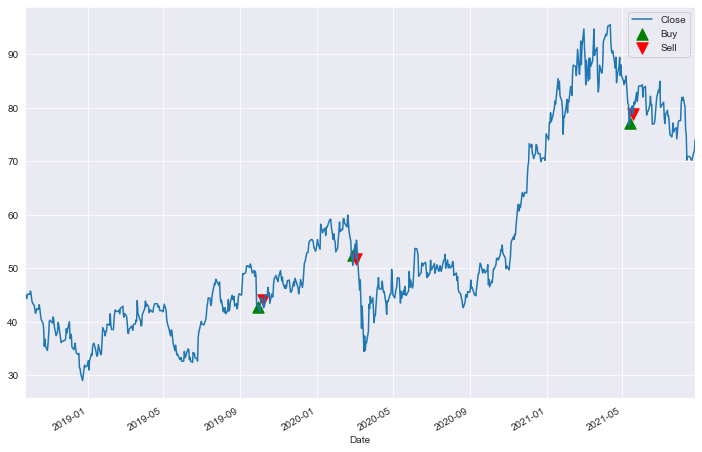

In [16]:
ax = df['Close'].plot(figsize=(12,8))
ax.scatter(buy_date, df.loc[buy_date].Close, marker='^', c='g', s=130, label='Buy')
ax.scatter(sell_date, df.loc[sell_date].Close, marker='v', c='r', s=130, label='Sell');
ax.autoscale(tight=True, axis='x');
ax.legend()
ax.grid;

#### Calculate the profit

In [17]:
buy_sell = pd.DataFrame({'Buy': df.loc[buy_date,'Open'], 
                         'Sell': df.loc[sell_date,'Open']})
buy_sell.tail(5)

,Buy,Sell
Date,,
2019-10-07,NaN,44.299999
2020-02-28,48.650002,NaN
2020-03-03,NaN,54.599998
2021-05-13,77.970001,NaN
2021-05-18,NaN,80.550003


In [18]:
buy_sell['Sell'] = buy_sell['Sell'].shift(-1)
buy_sell.dropna(inplace=True)

In [19]:
profit = (buy_sell.Sell - buy_sell.Buy)/buy_sell.Buy
win = [i for i in profit if i > 0]
pct_win = 100*len(win)/(len(profit)+1e-6)
print(f'Winning percentage: {np.round(pct_win, 2)}%')
print(f'Mean profit: {np.round(np.mean(profit*100), 2)}%')
print(f'Number of transactions: {len(profit)}')

Winning percentage: 100.0%
Mean profit: 6.19%
Number of transactions: 3


In [20]:
ret = (1 + profit).cumprod()
ret

Date
2019-09-30    1.030233
2020-02-28    1.156232
2021-05-13    1.194491
dtype: float64

In [21]:
# Store the average holding period
hold_day = []
for buy, sell in zip(buy_date, sell_date):
    hold_day.append(sell - buy)
print(f'Mean holding period: {np.mean(hold_day)}')

Mean holding period: 5 days 08:00:00


## Backtest multiple assets

#### Set the ticker symbols

In [22]:
stocks = pd.read_csv('data/nasdaq_screener_1626347395770.csv', index_col=0)
market_cap_lim = 5e10
stocks = stocks[stocks['Market Cap'] > market_cap_lim]

In [23]:
tickers = list(stocks.index)

In [24]:
add_list = ['ARKK', 'ARKG', 'ARKF', 'ARKW', 'ARKQ', '^GSPC', '^IXIC', 'ETH-USD', 'BTC-USD']
tickers.extend(add_list)
len(tickers)

249

In [25]:
# remove weird data
unwanted_list = ['GE','TTE']
tickers = [t for t in tickers if t not in unwanted_list]
len(tickers)

247

In [26]:
benchmark = ['^GSPC', '^IXIC']

#### Obtain the historical data

In [27]:
strategy = ['bband','rsi','rsi_bband']

In [28]:
hist_ori = pd.read_csv('data/historical_data_from_2015.csv', index_col=0, header=[0,1], parse_dates=True)

### 2016

In [29]:
start_date = '2016-01-01'
end_date = (pd.to_datetime(start_date) + relativedelta(years=1)).strftime('%Y-%m-%d')
data_start = (pd.to_datetime(start_date) - relativedelta(years=1)).strftime('%Y-%m-%d')
data_start, start_date, end_date

('2015-01-01', '2016-01-01', '2017-01-01')

In [30]:
hist = hist_ori.loc[data_start:end_date]

The effective annual return of ^GSPC is 11.37%
The effective annual return of ^IXIC is 9.9%


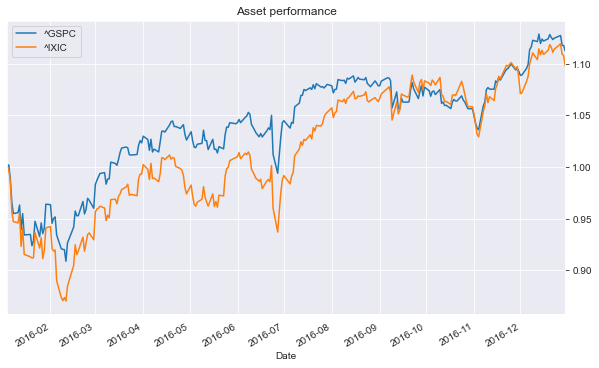

In [31]:
df2 = pd.DataFrame()
for idx in benchmark:
    df2[idx] = hist.loc[start_date:end_date][idx]['Close'].dropna()
    calc_effective_annual_return(df2[idx], name=idx)
ax = (df2/df2.iloc[0]).plot(figsize=(10,6),title='Asset performance')
ax.autoscale(tight=True, axis='x')
ax.yaxis.tick_right()

bband-------------------------------------------
Number of transactions: 574
Winning probability: 83.28%
Mean return: 5.17%
Mean profit: 7.27%
Mean loss: -5.33%
Kelly criterion: 71.02%
Mean holding period: 60.44 days
Annual effective return: 36.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 2969.0 USD after 574 number of transactions


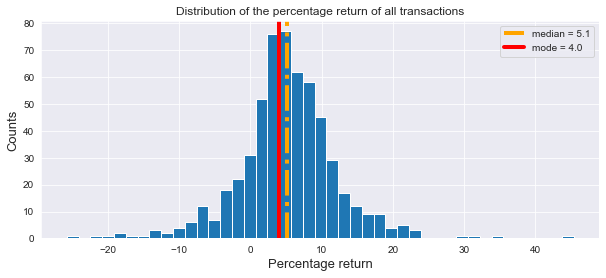

bband cut_loss----------------------------------
Number of transactions: 574
Winning probability: 83.28%
Mean return: 5.52%
Mean profit: 7.27%
Mean loss: -3.2%
Kelly criterion: 75.91%
Mean holding period: 60.44 days
Annual effective return: 38.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 3171.0 USD after 574 number of transactions


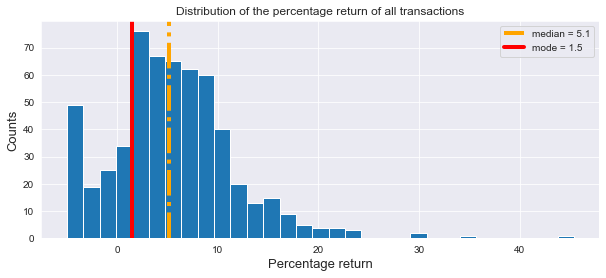

rsi-------------------------------------------
Number of transactions: 283
Winning probability: 74.91%
Mean return: 1.18%
Mean profit: 2.6%
Mean loss: -3.06%
Kelly criterion: 45.31%
Mean holding period: 7.16 days
Annual effective return: 82.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 333.0 USD after 283 number of transactions


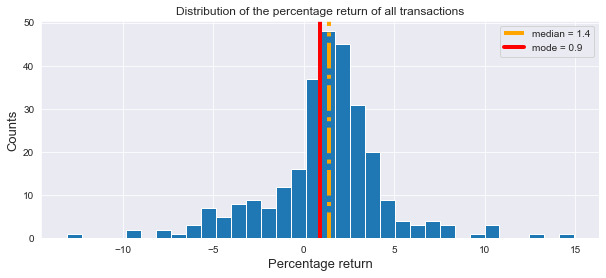

rsi cut_loss----------------------------------
Number of transactions: 283
Winning probability: 74.91%
Mean return: 1.28%
Mean profit: 2.6%
Mean loss: -2.66%
Kelly criterion: 49.26%
Mean holding period: 7.16 days
Annual effective return: 91.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 362.0 USD after 283 number of transactions


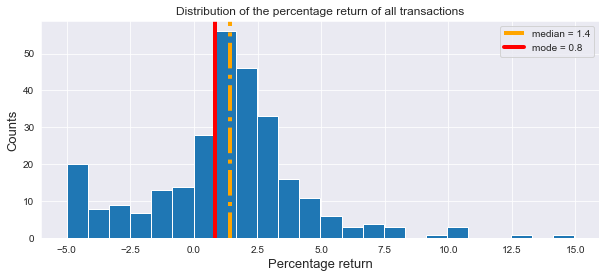

rsi_bband-------------------------------------------
Number of transactions: 240
Winning probability: 75.0%
Mean return: 1.15%
Mean profit: 2.56%
Mean loss: -3.08%
Kelly criterion: 44.85%
Mean holding period: 7.15 days
Annual effective return: 79.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 275.0 USD after 240 number of transactions


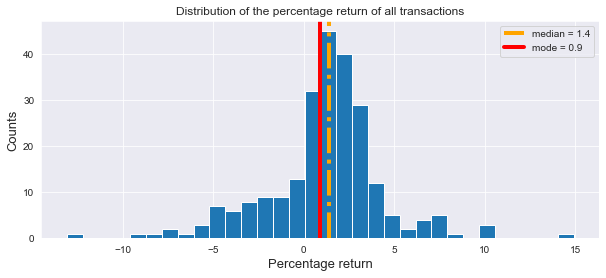

rsi_bband cut_loss----------------------------------
Number of transactions: 240
Winning probability: 75.0%
Mean return: 1.24%
Mean profit: 2.56%
Mean loss: -2.7%
Kelly criterion: 48.63%
Mean holding period: 7.15 days
Annual effective return: 88.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 298.0 USD after 240 number of transactions


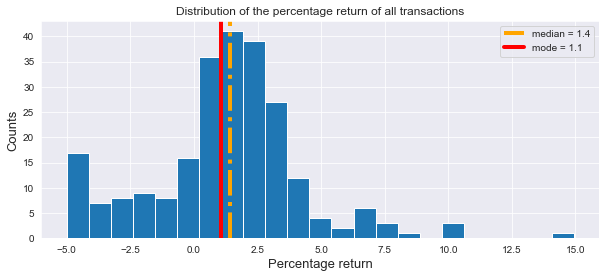

In [32]:
for st in strategy:
    print(f'{st}-------------------------------------------')
    matrixprofits, matrixholddays = backtest_strategy(tickers, hist, start_date, end_date, st)
    calc_backtest_profit(matrixprofits)
    calc_backtest_effective_annual_return(matrixprofits, matrixholddays)
    calc_backtest_bet_return(matrixprofits, one_bet=100)
    plot_backtest_profit_hist(matrixprofits, matrixholddays)
    print(f'{st} cut_loss----------------------------------')
    calc_backtest_profit(matrixprofits, cut_loss=-0.05)
    calc_backtest_effective_annual_return(matrixprofits, matrixholddays, cut_loss=-0.05)
    calc_backtest_bet_return(matrixprofits, one_bet=100, cut_loss=-0.05)
    plot_backtest_profit_hist(matrixprofits, matrixholddays, cut_loss=-0.05)

### 2017

In [33]:
start_date = '2017-01-01'
end_date = (pd.to_datetime(start_date) + relativedelta(years=1)).strftime('%Y-%m-%d')
data_start = (pd.to_datetime(start_date) - relativedelta(years=1)).strftime('%Y-%m-%d')
data_start, start_date, end_date

('2016-01-01', '2017-01-01', '2018-01-01')

In [34]:
hist = hist_ori.loc[data_start:end_date]

The effective annual return of ^GSPC is 18.69%
The effective annual return of ^IXIC is 27.58%


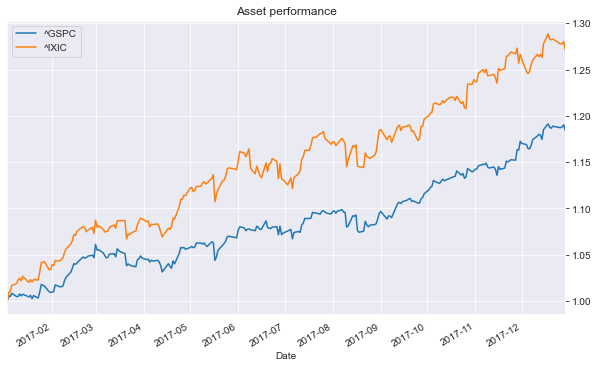

In [35]:
df2 = pd.DataFrame()
for idx in benchmark:
    df2[idx] = hist.loc[start_date:end_date][idx]['Close'].dropna()
    calc_effective_annual_return(df2[idx], name=idx)
ax = (df2/df2.iloc[0]).plot(figsize=(10,6),title='Asset performance')
ax.autoscale(tight=True, axis='x')
ax.yaxis.tick_right()

bband-------------------------------------------
Number of transactions: 521
Winning probability: 84.45%
Mean return: 4.29%
Mean profit: 5.81%
Mean loss: -4.0%
Kelly criterion: 73.74%
Mean holding period: 45.75 days
Annual effective return: 40.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 2233.0 USD after 521 number of transactions


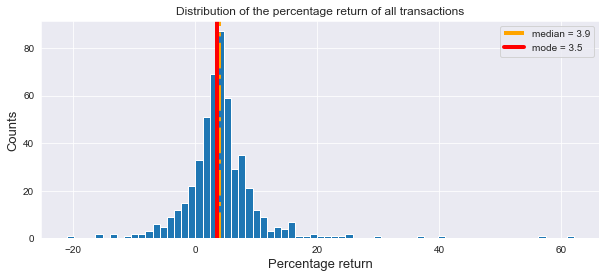

bband cut_loss----------------------------------
Number of transactions: 521
Winning probability: 84.45%
Mean return: 4.47%
Mean profit: 5.81%
Mean loss: -2.84%
Kelly criterion: 76.86%
Mean holding period: 45.75 days
Annual effective return: 42.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 2327.0 USD after 521 number of transactions


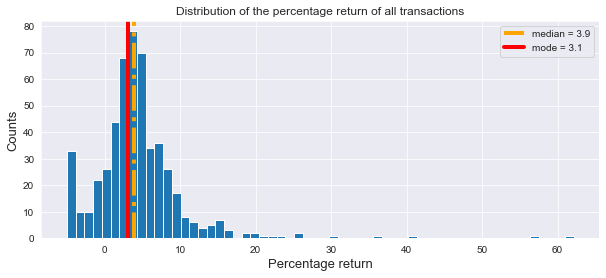

rsi-------------------------------------------
Number of transactions: 299
Winning probability: 75.59%
Mean return: 1.48%
Mean profit: 2.63%
Mean loss: -2.12%
Kelly criterion: 55.94%
Mean holding period: 7.39 days
Annual effective return: 107.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 443.0 USD after 299 number of transactions


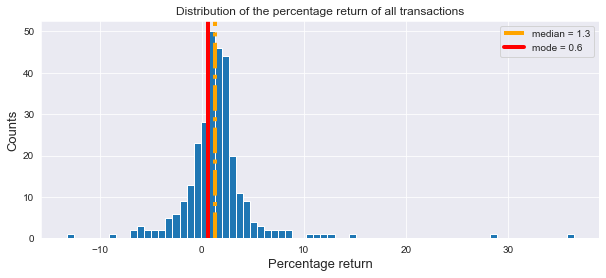

rsi cut_loss----------------------------------
Number of transactions: 299
Winning probability: 75.59%
Mean return: 1.54%
Mean profit: 2.63%
Mean loss: -1.86%
Kelly criterion: 58.35%
Mean holding period: 7.39 days
Annual effective return: 112.99999999999999%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 462.0 USD after 299 number of transactions


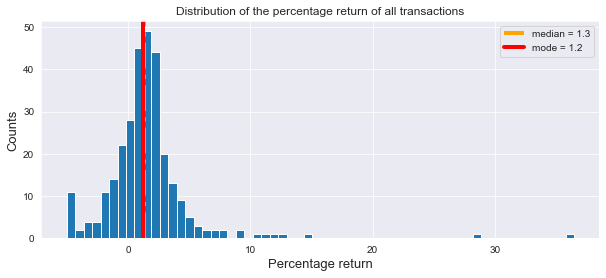

rsi_bband-------------------------------------------
Number of transactions: 248
Winning probability: 75.0%
Mean return: 1.59%
Mean profit: 2.87%
Mean loss: -2.31%
Kelly criterion: 54.89%
Mean holding period: 7.55 days
Annual effective return: 113.99999999999999%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 393.0 USD after 248 number of transactions


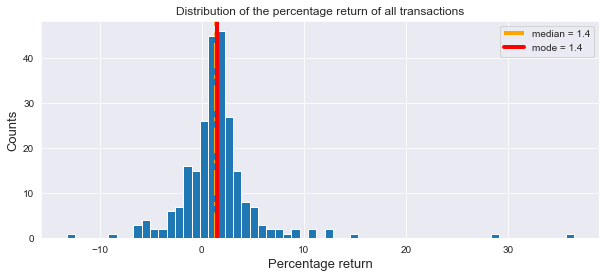

rsi_bband cut_loss----------------------------------
Number of transactions: 248
Winning probability: 75.0%
Mean return: 1.66%
Mean profit: 2.87%
Mean loss: -2.03%
Kelly criterion: 57.32%
Mean holding period: 7.55 days
Annual effective return: 121.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 411.0 USD after 248 number of transactions


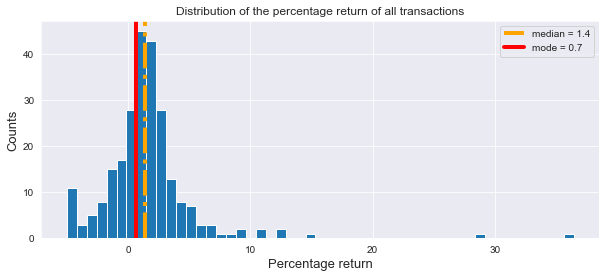

In [36]:
for st in strategy:
    print(f'{st}-------------------------------------------')
    matrixprofits, matrixholddays = backtest_strategy(tickers, hist, start_date, end_date, st)
    calc_backtest_profit(matrixprofits)
    calc_backtest_effective_annual_return(matrixprofits, matrixholddays)
    calc_backtest_bet_return(matrixprofits, one_bet=100)
    plot_backtest_profit_hist(matrixprofits, matrixholddays)
    print(f'{st} cut_loss----------------------------------')
    calc_backtest_profit(matrixprofits, cut_loss=-0.05)
    calc_backtest_effective_annual_return(matrixprofits, matrixholddays, cut_loss=-0.05)
    calc_backtest_bet_return(matrixprofits, one_bet=100, cut_loss=-0.05)
    plot_backtest_profit_hist(matrixprofits, matrixholddays, cut_loss=-0.05)

### 2018

In [37]:
start_date = '2018-01-01'
end_date = (pd.to_datetime(start_date) + relativedelta(years=1)).strftime('%Y-%m-%d')
data_start = (pd.to_datetime(start_date) - relativedelta(years=1)).strftime('%Y-%m-%d')
data_start, start_date, end_date

('2017-01-01', '2018-01-01', '2019-01-01')

In [38]:
hist = hist_ori.loc[data_start:end_date]

The effective annual return of ^GSPC is -7.05%
The effective annual return of ^IXIC is -5.33%


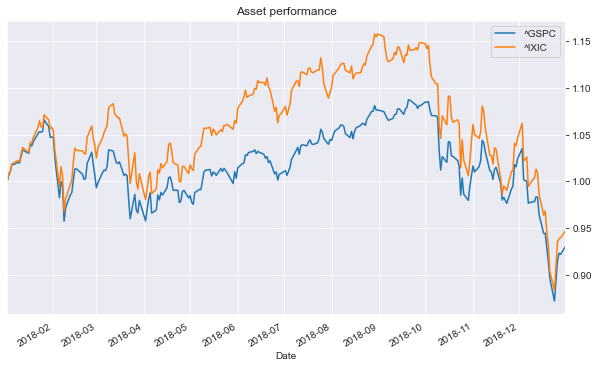

In [39]:
df2 = pd.DataFrame()
for idx in benchmark:
    df2[idx] = hist.loc[start_date:end_date][idx]['Close'].dropna()
    calc_effective_annual_return(df2[idx], name=idx)
ax = (df2/df2.iloc[0]).plot(figsize=(10,6),title='Asset performance')
ax.autoscale(tight=True, axis='x')
ax.yaxis.tick_right()

bband-------------------------------------------
Number of transactions: 528
Winning probability: 72.35%
Mean return: 3.15%
Mean profit: 7.33%
Mean loss: -7.79%
Kelly criterion: 42.93%
Mean holding period: 50.61 days
Annual effective return: 25.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 1661.0 USD after 528 number of transactions


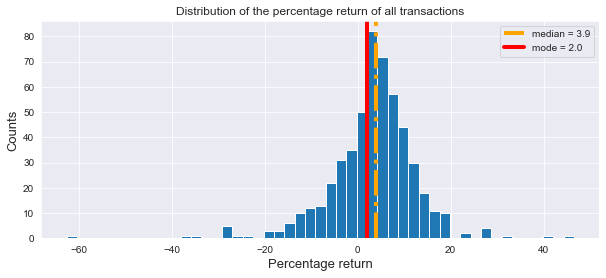

bband cut_loss----------------------------------
Number of transactions: 528
Winning probability: 72.35%
Mean return: 4.27%
Mean profit: 7.33%
Mean loss: -3.74%
Kelly criterion: 58.25%
Mean holding period: 50.61 days
Annual effective return: 35.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 2253.0 USD after 528 number of transactions


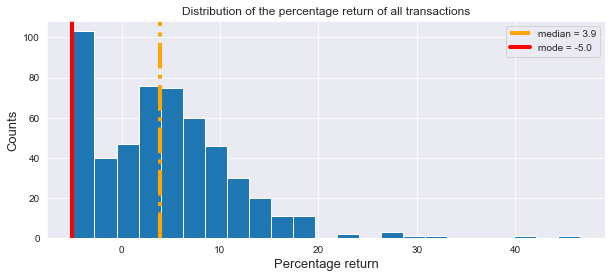

rsi-------------------------------------------
Number of transactions: 349
Winning probability: 74.5%
Mean return: 1.4%
Mean profit: 3.02%
Mean loss: -3.38%
Kelly criterion: 45.97%
Mean holding period: 6.8 days
Annual effective return: 111.00000000000001%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 488.0 USD after 349 number of transactions


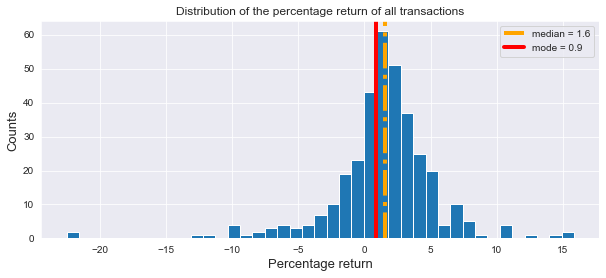

rsi cut_loss----------------------------------
Number of transactions: 349
Winning probability: 74.5%
Mean return: 1.65%
Mean profit: 3.02%
Mean loss: -2.37%
Kelly criterion: 54.49%
Mean holding period: 6.8 days
Annual effective return: 141.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 576.0 USD after 349 number of transactions


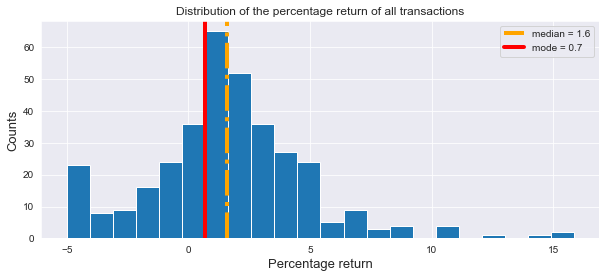

rsi_bband-------------------------------------------
Number of transactions: 293
Winning probability: 75.09%
Mean return: 1.41%
Mean profit: 3.03%
Mean loss: -3.46%
Kelly criterion: 46.59%
Mean holding period: 6.93 days
Annual effective return: 109.00000000000001%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 413.0 USD after 293 number of transactions


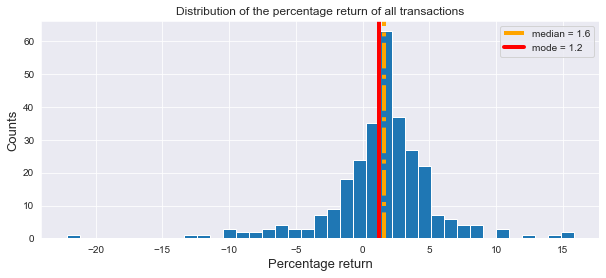

rsi_bband cut_loss----------------------------------
Number of transactions: 293
Winning probability: 75.09%
Mean return: 1.65%
Mean profit: 3.03%
Mean loss: -2.48%
Kelly criterion: 54.62%
Mean holding period: 6.93 days
Annual effective return: 137.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 484.0 USD after 293 number of transactions


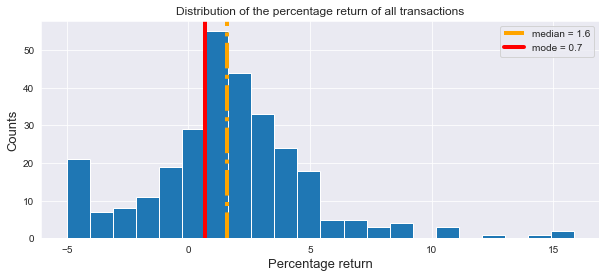

In [40]:
for st in strategy:
    print(f'{st}-------------------------------------------')
    matrixprofits, matrixholddays = backtest_strategy(tickers, hist, start_date, end_date, st)
    calc_backtest_profit(matrixprofits)
    calc_backtest_effective_annual_return(matrixprofits, matrixholddays)
    calc_backtest_bet_return(matrixprofits, one_bet=100)
    plot_backtest_profit_hist(matrixprofits, matrixholddays)
    print(f'{st} cut_loss----------------------------------')
    calc_backtest_profit(matrixprofits, cut_loss=-0.05)
    calc_backtest_effective_annual_return(matrixprofits, matrixholddays, cut_loss=-0.05)
    calc_backtest_bet_return(matrixprofits, one_bet=100, cut_loss=-0.05)
    plot_backtest_profit_hist(matrixprofits, matrixholddays, cut_loss=-0.05)

### 2019

In [41]:
start_date = '2019-01-01'
end_date = (pd.to_datetime(start_date) + relativedelta(years=1)).strftime('%Y-%m-%d')
data_start = (pd.to_datetime(start_date) - relativedelta(years=1)).strftime('%Y-%m-%d')
data_start, start_date, end_date

('2018-01-01', '2019-01-01', '2020-01-01')

In [42]:
hist = hist_ori.loc[data_start:end_date]

The effective annual return of ^GSPC is 28.89%
The effective annual return of ^IXIC is 34.82%


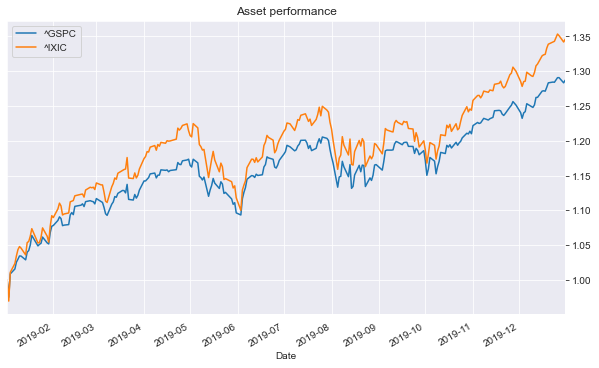

In [43]:
df2 = pd.DataFrame()
for idx in benchmark:
    df2[idx] = hist.loc[start_date:end_date][idx]['Close'].dropna()
    calc_effective_annual_return(df2[idx], name=idx)
ax = (df2/df2.iloc[0]).plot(figsize=(10,6),title='Asset performance')
ax.autoscale(tight=True, axis='x')
ax.yaxis.tick_right()

bband-------------------------------------------
Number of transactions: 580
Winning probability: 78.28%
Mean return: 4.43%
Mean profit: 7.36%
Mean loss: -6.17%
Kelly criterion: 60.08%
Mean holding period: 57.77 days
Annual effective return: 32.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 2572.0 USD after 580 number of transactions


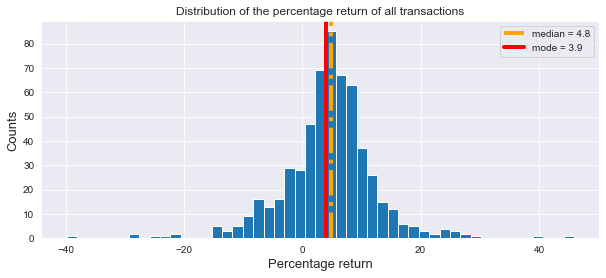

bband cut_loss----------------------------------
Number of transactions: 580
Winning probability: 78.28%
Mean return: 5.02%
Mean profit: 7.36%
Mean loss: -3.45%
Kelly criterion: 68.11%
Mean holding period: 57.77 days
Annual effective return: 36.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 2912.0 USD after 580 number of transactions


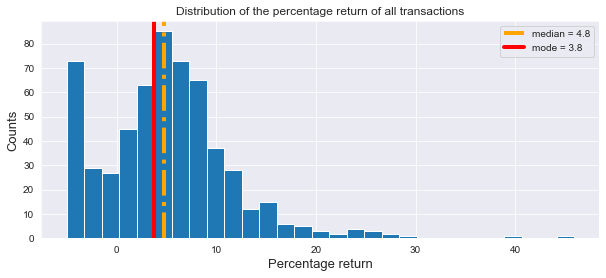

rsi-------------------------------------------
Number of transactions: 226
Winning probability: 73.01%
Mean return: 0.62%
Mean profit: 2.32%
Mean loss: -3.96%
Kelly criterion: 26.87%
Mean holding period: 7.1 days
Annual effective return: 38.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 141.0 USD after 226 number of transactions


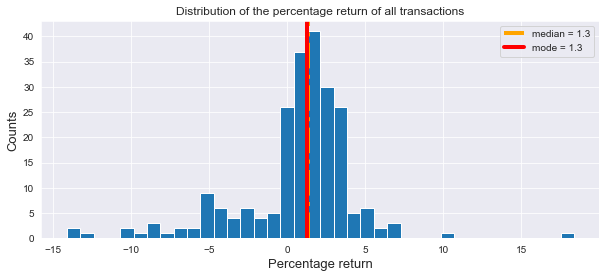

rsi cut_loss----------------------------------
Number of transactions: 226
Winning probability: 73.01%
Mean return: 0.89%
Mean profit: 2.32%
Mean loss: -2.98%
Kelly criterion: 38.36%
Mean holding period: 7.1 days
Annual effective return: 57.99999999999999%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 201.0 USD after 226 number of transactions


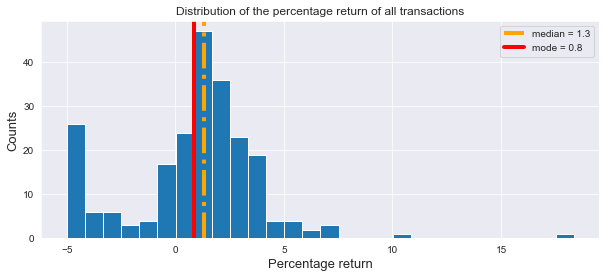

rsi_bband-------------------------------------------
Number of transactions: 205
Winning probability: 72.2%
Mean return: 0.64%
Mean profit: 2.41%
Mean loss: -3.94%
Kelly criterion: 26.65%
Mean holding period: 7.01 days
Annual effective return: 40.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 132.0 USD after 205 number of transactions


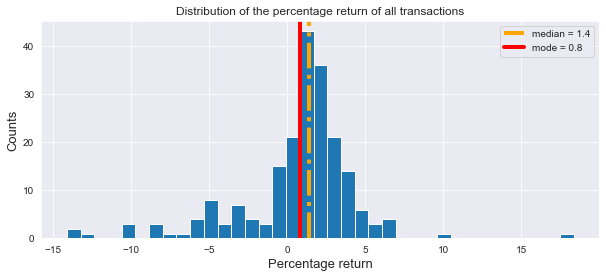

rsi_bband cut_loss----------------------------------
Number of transactions: 205
Winning probability: 72.2%
Mean return: 0.92%
Mean profit: 2.41%
Mean loss: -2.93%
Kelly criterion: 38.33%
Mean holding period: 7.01 days
Annual effective return: 61.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 189.0 USD after 205 number of transactions


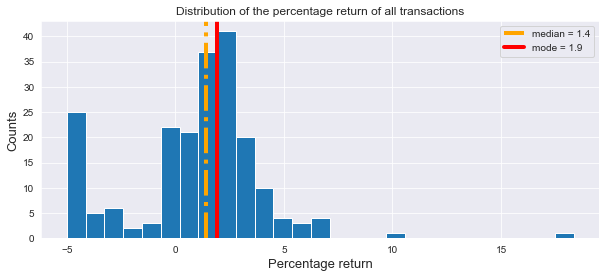

In [44]:
for st in strategy:
    print(f'{st}-------------------------------------------')
    matrixprofits, matrixholddays = backtest_strategy(tickers, hist, start_date, end_date, st)
    calc_backtest_profit(matrixprofits)
    calc_backtest_effective_annual_return(matrixprofits, matrixholddays)
    calc_backtest_bet_return(matrixprofits, one_bet=100)
    plot_backtest_profit_hist(matrixprofits, matrixholddays)
    print(f'{st} cut_loss----------------------------------')
    calc_backtest_profit(matrixprofits, cut_loss=-0.05)
    calc_backtest_effective_annual_return(matrixprofits, matrixholddays, cut_loss=-0.05)
    calc_backtest_bet_return(matrixprofits, one_bet=100, cut_loss=-0.05)
    plot_backtest_profit_hist(matrixprofits, matrixholddays, cut_loss=-0.05)

### 2020

In [45]:
start_date = '2020-01-01'
end_date = (pd.to_datetime(start_date) + relativedelta(years=1)).strftime('%Y-%m-%d')
data_start = (pd.to_datetime(start_date) - relativedelta(years=1)).strftime('%Y-%m-%d')
data_start, start_date, end_date

('2019-01-01', '2020-01-01', '2021-01-01')

In [46]:
hist = hist_ori.loc[data_start:end_date]

The effective annual return of ^GSPC is 15.34%
The effective annual return of ^IXIC is 41.89%


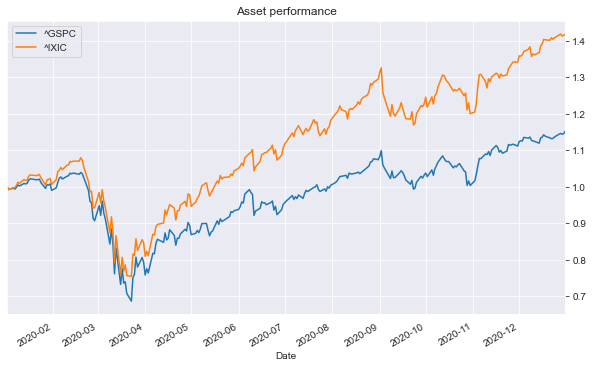

In [47]:
df2 = pd.DataFrame()
for idx in benchmark:
    df2[idx] = hist.loc[start_date:end_date][idx]['Close'].dropna()
    calc_effective_annual_return(df2[idx], name=idx)
ax = (df2/df2.iloc[0]).plot(figsize=(10,6),title='Asset performance')
ax.autoscale(tight=True, axis='x')
ax.yaxis.tick_right()

bband-------------------------------------------
Number of transactions: 557
Winning probability: 68.58%
Mean return: 3.54%
Mean profit: 11.01%
Mean loss: -12.77%
Kelly criterion: 32.14%
Mean holding period: 52.79 days
Annual effective return: 27.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 1970.0 USD after 557 number of transactions


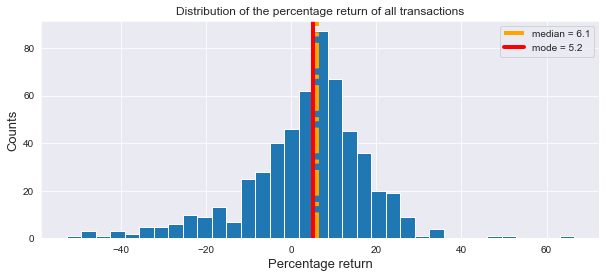

bband cut_loss----------------------------------
Number of transactions: 557
Winning probability: 68.58%
Mean return: 6.24%
Mean profit: 11.01%
Mean loss: -4.18%
Kelly criterion: 56.66%
Mean holding period: 52.79 days
Annual effective return: 52.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 3474.0 USD after 557 number of transactions


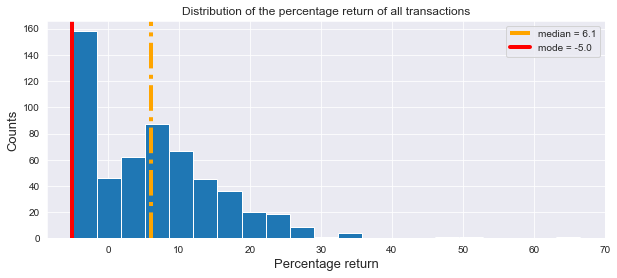

rsi-------------------------------------------
Number of transactions: 242
Winning probability: 71.49%
Mean return: 0.92%
Mean profit: 4.67%
Mean loss: -8.5%
Kelly criterion: 19.63%
Mean holding period: 6.96 days
Annual effective return: 61.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 222.0 USD after 242 number of transactions


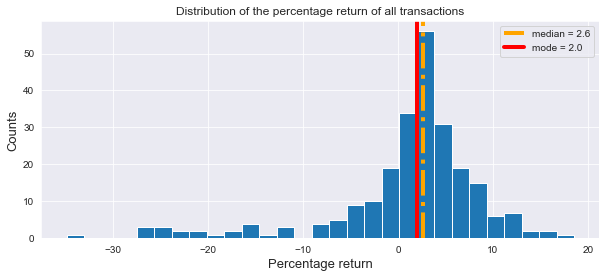

rsi cut_loss----------------------------------
Number of transactions: 242
Winning probability: 71.49%
Mean return: 2.37%
Mean profit: 4.67%
Mean loss: -3.42%
Kelly criterion: 50.62%
Mean holding period: 6.96 days
Annual effective return: 241.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 573.0 USD after 242 number of transactions


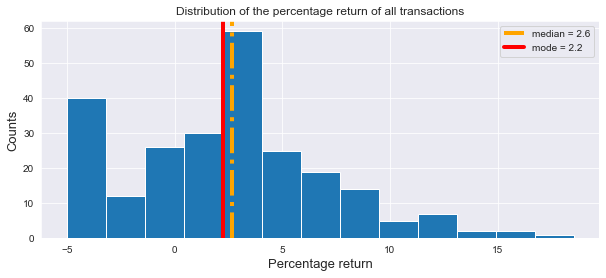

rsi_bband-------------------------------------------
Number of transactions: 216
Winning probability: 70.37%
Mean return: 0.9%
Mean profit: 4.67%
Mean loss: -8.04%
Kelly criterion: 19.31%
Mean holding period: 7.13 days
Annual effective return: 57.99999999999999%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 195.0 USD after 216 number of transactions


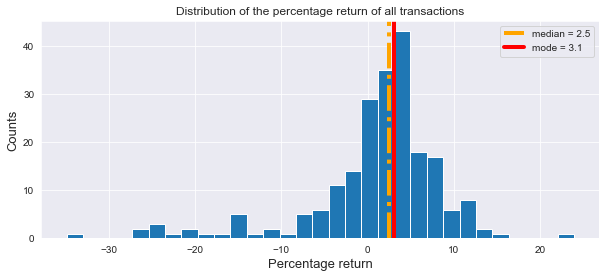

rsi_bband cut_loss----------------------------------
Number of transactions: 216
Winning probability: 70.37%
Mean return: 2.27%
Mean profit: 4.67%
Mean loss: -3.41%
Kelly criterion: 48.73%
Mean holding period: 7.13 days
Annual effective return: 216.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 491.0 USD after 216 number of transactions


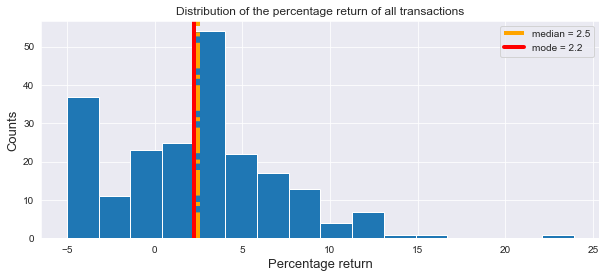

In [48]:
for st in strategy:
    print(f'{st}-------------------------------------------')
    matrixprofits, matrixholddays = backtest_strategy(tickers, hist, start_date, end_date, st)
    calc_backtest_profit(matrixprofits)
    calc_backtest_effective_annual_return(matrixprofits, matrixholddays)
    calc_backtest_bet_return(matrixprofits, one_bet=100)
    plot_backtest_profit_hist(matrixprofits, matrixholddays)
    print(f'{st} cut_loss----------------------------------')
    calc_backtest_profit(matrixprofits, cut_loss=-0.05)
    calc_backtest_effective_annual_return(matrixprofits, matrixholddays, cut_loss=-0.05)
    calc_backtest_bet_return(matrixprofits, one_bet=100, cut_loss=-0.05)
    plot_backtest_profit_hist(matrixprofits, matrixholddays, cut_loss=-0.05)

### 2021

In [49]:
start_date = '2021-01-01'
end_date = (pd.to_datetime(start_date) + relativedelta(years=1)).strftime('%Y-%m-%d')
data_start = (pd.to_datetime(start_date) - relativedelta(years=1)).strftime('%Y-%m-%d')
data_start, start_date, end_date

('2020-01-01', '2021-01-01', '2022-01-01')

In [50]:
hist = hist_ori.loc[data_start:end_date]

The effective annual return of ^GSPC is 33.94%
The effective annual return of ^IXIC is 26.61%


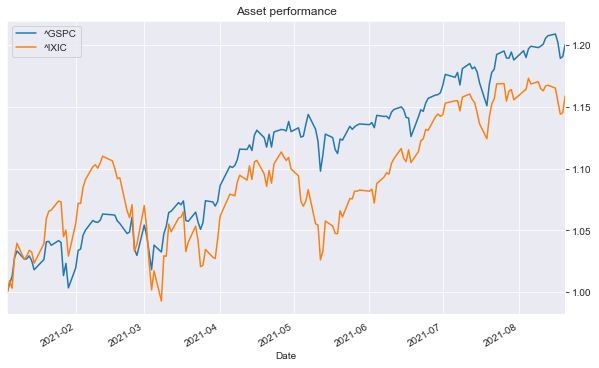

In [51]:
df2 = pd.DataFrame()
for idx in benchmark:
    df2[idx] = hist.loc[start_date:end_date][idx]['Close'].dropna()
    calc_effective_annual_return(df2[idx], name=idx)
ax = (df2/df2.iloc[0]).plot(figsize=(10,6),title='Asset performance')
ax.autoscale(tight=True, axis='x')
ax.yaxis.tick_right()

bband-------------------------------------------
Number of transactions: 378
Winning probability: 85.98%
Mean return: 5.8%
Mean profit: 7.56%
Mean loss: -4.96%
Kelly criterion: 76.77%
Mean holding period: 51.5 days
Annual effective return: 49.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 2193.0 USD after 378 number of transactions


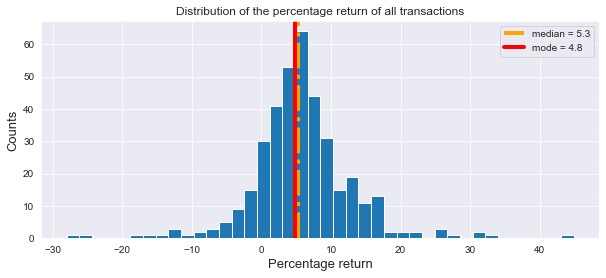

bband cut_loss----------------------------------
Number of transactions: 378
Winning probability: 85.98%
Mean return: 6.1%
Mean profit: 7.56%
Mean loss: -2.81%
Kelly criterion: 80.77%
Mean holding period: 51.5 days
Annual effective return: 52.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 2307.0 USD after 378 number of transactions


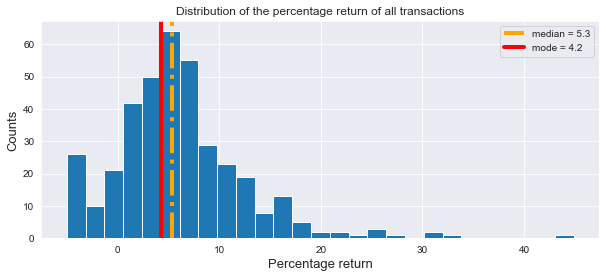

rsi-------------------------------------------
Number of transactions: 271
Winning probability: 76.01%
Mean return: 1.69%
Mean profit: 3.12%
Mean loss: -2.82%
Kelly criterion: 54.27%
Mean holding period: 6.31 days
Annual effective return: 164.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 458.0 USD after 271 number of transactions


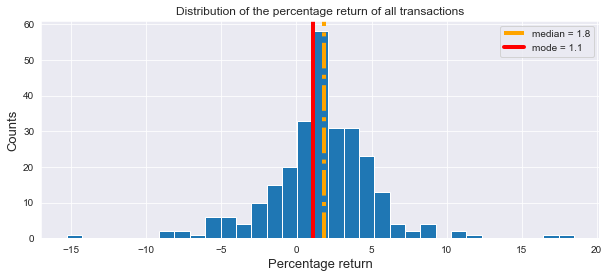

rsi cut_loss----------------------------------
Number of transactions: 271
Winning probability: 76.01%
Mean return: 1.8%
Mean profit: 3.12%
Mean loss: -2.39%
Kelly criterion: 57.65%
Mean holding period: 6.31 days
Annual effective return: 180.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 487.0 USD after 271 number of transactions


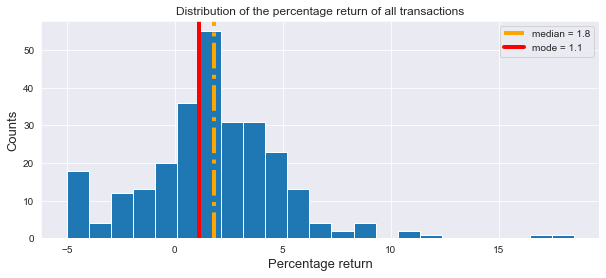

rsi_bband-------------------------------------------
Number of transactions: 246
Winning probability: 76.02%
Mean return: 1.69%
Mean profit: 3.17%
Mean loss: -3.02%
Kelly criterion: 53.2%
Mean holding period: 6.42 days
Annual effective return: 159.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 415.0 USD after 246 number of transactions


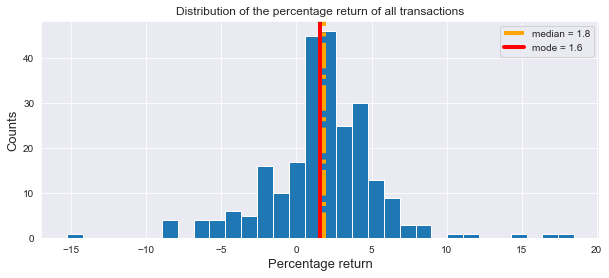

rsi_bband cut_loss----------------------------------
Number of transactions: 246
Winning probability: 76.02%
Mean return: 1.8%
Mean profit: 3.17%
Mean loss: -2.53%
Kelly criterion: 56.86%
Mean holding period: 6.42 days
Annual effective return: 176.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 444.0 USD after 246 number of transactions


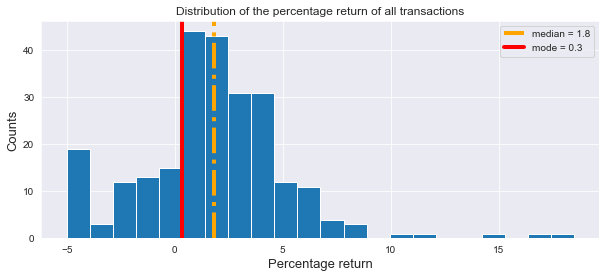

In [52]:
for st in strategy:
    print(f'{st}-------------------------------------------')
    matrixprofits, matrixholddays = backtest_strategy(tickers, hist, start_date, end_date, st)
    calc_backtest_profit(matrixprofits)
    calc_backtest_effective_annual_return(matrixprofits, matrixholddays)
    calc_backtest_bet_return(matrixprofits, one_bet=100)
    plot_backtest_profit_hist(matrixprofits, matrixholddays)
    print(f'{st} cut_loss----------------------------------')
    calc_backtest_profit(matrixprofits, cut_loss=-0.05)
    calc_backtest_effective_annual_return(matrixprofits, matrixholddays, cut_loss=-0.05)
    calc_backtest_bet_return(matrixprofits, one_bet=100, cut_loss=-0.05)
    plot_backtest_profit_hist(matrixprofits, matrixholddays, cut_loss=-0.05)

### Last five years

In [53]:
start_date = datetime.now() - relativedelta(years=5)
data_start = start_date - relativedelta(years=1)
start_date = start_date.strftime('%Y-%m-%d')
data_start = data_start.strftime('%Y-%m-%d')
end_date = str(datetime.now().strftime('%Y-%m-%d'))
data_start, start_date, end_date

('2015-08-26', '2016-08-26', '2021-08-26')

In [54]:
hist = hist_ori.loc[data_start:end_date]

The effective annual return of ^GSPC is 15.46%
The effective annual return of ^IXIC is 23.11%


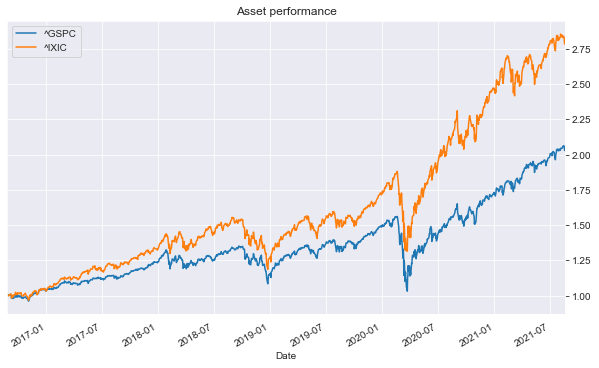

In [55]:
df2 = pd.DataFrame()
for idx in benchmark:
    df2[idx] = hist.loc[start_date:end_date][idx]['Close'].dropna()
    calc_effective_annual_return(df2[idx], name=idx)
ax = (df2/df2.iloc[0]).plot(figsize=(10,6),title='Asset performance')
ax.autoscale(tight=True, axis='x')
ax.yaxis.tick_right()

bband-------------------------------------------
Number of transactions: 3204
Winning probability: 75.84%
Mean return: 3.81%
Mean profit: 7.73%
Mean loss: -8.52%
Kelly criterion: 49.22%
Mean holding period: 53.87 days
Annual effective return: 28.999999999999996%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 12199.0 USD after 3204 number of transactions


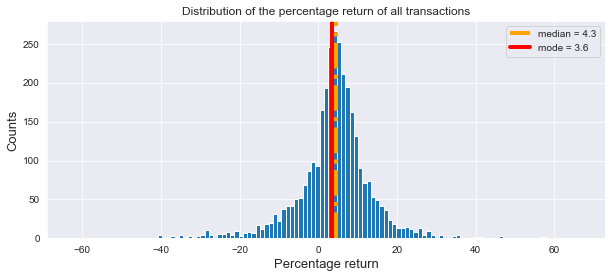

bband cut_loss----------------------------------
Number of transactions: 3204
Winning probability: 75.84%
Mean return: 4.97%
Mean profit: 7.73%
Mean loss: -3.68%
Kelly criterion: 64.34%
Mean holding period: 53.87 days
Annual effective return: 39.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 15938.0 USD after 3204 number of transactions


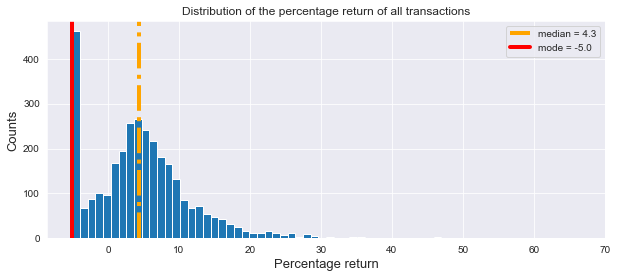

rsi-------------------------------------------
Number of transactions: 1582
Winning probability: 74.27%
Mean return: 1.24%
Mean profit: 3.02%
Mean loss: -3.95%
Kelly criterion: 40.69%
Mean holding period: 6.94 days
Annual effective return: 91.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 1955.0 USD after 1582 number of transactions


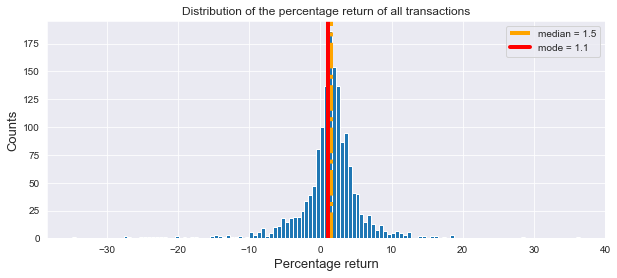

rsi cut_loss----------------------------------
Number of transactions: 1582
Winning probability: 74.27%
Mean return: 1.59%
Mean profit: 3.02%
Mean loss: -2.55%
Kelly criterion: 52.56%
Mean holding period: 6.94 days
Annual effective return: 130.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 2520.0 USD after 1582 number of transactions


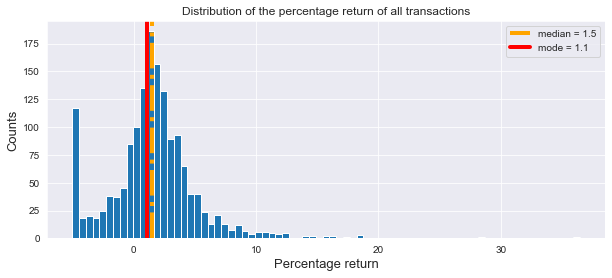

rsi_bband-------------------------------------------
Number of transactions: 1368
Winning probability: 74.27%
Mean return: 1.27%
Mean profit: 3.1%
Mean loss: -4.03%
Kelly criterion: 40.82%
Mean holding period: 6.99 days
Annual effective return: 93.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 1735.0 USD after 1368 number of transactions


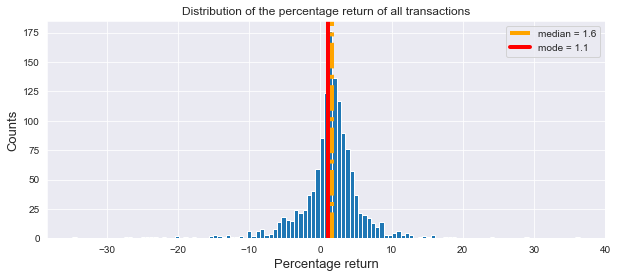

rsi_bband cut_loss----------------------------------
Number of transactions: 1368
Winning probability: 74.27%
Mean return: 1.62%
Mean profit: 3.1%
Mean loss: -2.66%
Kelly criterion: 52.19%
Mean holding period: 6.99 days
Annual effective return: 131.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 2216.0 USD after 1368 number of transactions


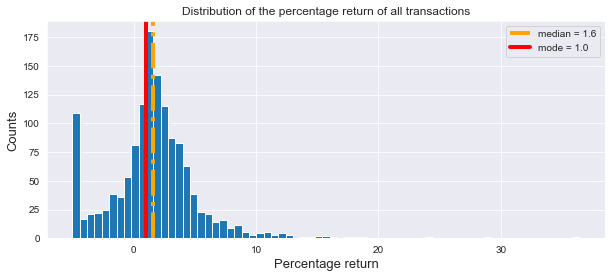

In [56]:
for st in strategy:
    print(f'{st}-------------------------------------------')
    matrixprofits, matrixholddays = backtest_strategy(tickers, hist, start_date, end_date, st)
    calc_backtest_profit(matrixprofits)
    calc_backtest_effective_annual_return(matrixprofits, matrixholddays)
    calc_backtest_bet_return(matrixprofits, one_bet=100)
    plot_backtest_profit_hist(matrixprofits, matrixholddays)
    print(f'{st} cut_loss----------------------------------')
    calc_backtest_profit(matrixprofits, cut_loss=-0.05)
    calc_backtest_effective_annual_return(matrixprofits, matrixholddays, cut_loss=-0.05)
    calc_backtest_bet_return(matrixprofits, one_bet=100, cut_loss=-0.05)
    plot_backtest_profit_hist(matrixprofits, matrixholddays, cut_loss=-0.05)